In [30]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from musint.datasets.babel_dataset import BabelDataset
from musint.datasets.amass_dataset_utils import get_feat_p
import torch
import torch.nn.functional as F

from musint.benchmarks.muscle_sets import MUSCLE_SUBSETS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
babel_root = "/lsdf/data/activity/BABEL/babel_v1-0_release"

babel_paths = [
    os.path.join(babel_root, "train.json"),
    os.path.join(babel_root, "val.json"),
    os.path.join(babel_root, "test.json"),
    os.path.join(babel_root, "extra_train.json"),
    os.path.join(babel_root, "extra_val.json"),
]

babel_dataset = BabelDataset.from_datasets([BabelDataset.from_json_file(bp) for bp in babel_paths])

Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 1703, len(frame_ann_data): 5
Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 8165, len(frame_ann_data): 4
Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 5211, len(frame_ann_data): 4
Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 12633, len(frame_ann_data): 4
Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 1432, len(frame_ann_data): 4
Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 4857, len(frame_ann_data): 4
Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 11852, len(frame_ann_data): 4
Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 10436, len(frame_ann_data): 4
Frame annotations are ambiguous. Choosing first annotation. Split: None, babel_sid 3105, len(frame_an

In [32]:
def load_muscle_activations_meta(
    csv_path,
):
    all_segments = pd.read_csv(csv_path)

    all_segments = all_segments.astype(str)  # Change all other columns to str
    all_segments[["height_cm", "weight_kg", "babel_sid"]] = all_segments[
        ["height_cm", "weight_kg", "babel_sid"]
    ].astype(float)
    all_segments["babel_sid"] = all_segments["babel_sid"].fillna(-1)
    all_segments[["babel_sid"]] = all_segments[["babel_sid"]].astype(int)

    return all_segments


# Load Muscle Activation Data
muscle_activations = load_muscle_activations_meta(
    csv_path=os.path.expandvars("$LSDF/data/activity/MuscleSim/MusclesInTime.csv")
)

muscle_activations.iloc[0]["data_path"]

'rub029/0020_lifting_heavy2_poses/muscle_activations.pkl'

In [33]:
def find_strings(data):
    strings = []

    def recurse(item):
        if isinstance(item, (list, tuple)):
            for sub_item in item:
                recurse(sub_item)
        elif isinstance(item, str):
            strings.append(item)

    recurse(data)
    return strings

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from musint.benchmarks.muscle_sets import MUSCLE_SUBSETS

# from musint.muscle_groups.lu_muscle_groups import knee_flexion_l_muscles

# muscle_act_root = "/lsdf/users/mkugler/repositories/MuscleChat/output/transformer/output/transformer/16_trans_layers_256_width_28frames_2/muscle_activation/transformer"
muscle_act_root = "output/lstm/8_lstm_layers_256_width_28frames/muscle_activation/exp_debug"

metadata_df = pd.read_csv(
    "/lsdf/users/mkugler/repositories/MuscleChat/output/vqvae/vqvae/VQVAE/metadata.csv"
)  # Does not need to be changed (should be same for all models)

channel_annotations = MUSCLE_SUBSETS["MUSINT_402"]

with open(
    os.path.expandvars(
        "$LSDF/data/activity/MuscleSim/" + metadata_df.iloc[0]["name"] + "_poses/muscle_activations.pkl"
    ),
    "rb",
) as f:
    muscle_df: pd.DataFrame = pickle.load(f)

muscle_df = muscle_df[channel_annotations]

In [35]:
def compute_loss(Loss, pred_muscle_act, gt_muscle_act):
    loss_muscle_act = Loss.forward_naive(pred_muscle_act, gt_muscle_act)
    return loss_muscle_act

In [36]:
import torch


def pearson_corr(x, y):
    # x and y are of shape (B, T, C)
    B, T, C = x.shape

    mean_x = torch.mean(x, dim=1, keepdim=True)
    mean_y = torch.mean(y, dim=1, keepdim=True)

    std_x = torch.std(x, dim=1, keepdim=True, unbiased=False)
    std_y = torch.std(y, dim=1, keepdim=True, unbiased=False)

    x_norm = (x - mean_x) / (std_x + 1e-8)
    y_norm = (y - mean_y) / (std_y + 1e-8)

    numerator = torch.sum(x_norm * y_norm, dim=1)
    denominator = T - 1
    pcorrs = numerator / denominator

    mean_pcorr = torch.mean(pcorrs, dim=-1)

    return mean_pcorr, pcorrs


def smape(x, y):
    # x and y are of shape (B, T, C)
    B, T, C = x.shape

    numerator = torch.abs(x - y)
    denominator = (torch.abs(x) + torch.abs(y)) / 2.0

    smape_values = numerator / (denominator + 1e-8)  # Add small value to avoid division by zero
    smape_per_channel = torch.mean(smape_values, dim=1) * 100  # Compute mean across time dimension

    mean_smape = torch.mean(smape_per_channel, dim=-1)  # Compute mean across channels

    return mean_smape, smape_per_channel

In [37]:
index = 0  # Initialize index variable

subset_actions = [
    "overall",
    "jump",
    "kick",
    "stand",
    "walk",
    "jog",
    "dance",
    "overall",
]  # List to store subset actions

lu_muscle_count = 80  # Number of muscles in the lower body

print(muscle_act_root)
for mu_sub in [
    "MUSINT_402",
    "LU_MUSCLES",
    "TL_MUSCLES",
    # "LAI_ARNOLD_LOWER_BODY_16",
    # "LAI_ARNOLD_LOWER_BODY_8",
]:  # , "TL_MUSCLES"]:

    print(f"\nMuscle subset: {mu_sub}\n")
    muscle_idxs = [i for i, mus in enumerate(MUSCLE_SUBSETS["MUSINT_402"]) if mus in MUSCLE_SUBSETS[mu_sub]]

    print("Action & RMSE & PCorr & SMAPE")  # Print table header
    for subset_action in subset_actions:
        squared_errors = []  # List to store squared error values
        motion = "jump"  # Specify the motion type
        show_plot = False  # Flag to control plotting
        min_loss = float("inf")  # Initialize minimum loss
        max_loss = float("-inf")  # Initialize maximum loss
        min_loss_sample = None  # Initialize minimum loss sample
        max_loss_sample = None  # Initialize maximum loss sample
        all_losses = []  # List to store all loss values

        indices = []
        preds = []  # List to store predictions
        gts = []  # List to store ground truths
        acts = []  # List to store actions
        mean_pcorrs = []  # List to store mean pearson correlation values
        pcorr_cs = []  # List to store pearson correlation values by channel

        mean_smapes = []  # List to store mean smape values
        smapes_c = []  # List to store smape values by channel

        sub_meta_df = None

        # Iterate over each row in the metadata DataFrame
        for index, row in metadata_df.iterrows():
            # Retrieve start time and compute end time for the window
            time_start = row["time_start"]
            time_end = time_start + 64 / 20

            # Get ground truth and prediction file names from the row
            gt_file = row["gt_name"]
            pred_file = row["pred_name"]

            bdat = None  # Initialize bdat to None

            # Extract subject and sequence from the row name
            subject = row["name"].split("/")[0]
            sequence = row["name"].split("/")[1] + "_poses"

            try:
                # Retrieve dataset by feature path
                bdat = babel_dataset.by_feat_p(get_feat_p(subject, sequence))
            except KeyError:
                bdat = None  # Reset bdat to None
                continue  # Skip iteration if KeyError occurs

            if bdat is None:
                continue  # Skip iteration if bdat is None

            # Find unique actions in the specified time range
            all_acts = list(set(find_strings(bdat.clip_actions_in_range(time_start, time_end))))
            if subset_action != "overall" and not any(subset_action in act for act in all_acts):
                continue

            indices.append(index)  # Aligned index list with predictions.

            acts.append(all_acts)  # Append actions to the list

            # Construct paths for ground truth and prediction files
            gt_path = os.path.join(muscle_act_root, gt_file)
            pred_path = os.path.join(muscle_act_root, pred_file)

            # Load ground truth and prediction data
            gt = np.load(gt_path)[..., muscle_idxs]
            pred = np.load(pred_path)[..., muscle_idxs]

            # Convert numpy arrays to torch tensors
            torch_gt = torch.from_numpy(gt)
            torch_pred = torch.from_numpy(pred)

            mean_pcorr, pcorr_c = pearson_corr(torch_gt, torch_pred)
            mean_pcorrs.append(mean_pcorr)  # Append mean pearson correlation to list
            pcorr_cs.append(pcorr_c)  # Append pearson correlation to list

            mean_smape, smape_c = smape(torch_gt, torch_pred)
            mean_smapes.append(mean_smape)  # Append mean smape to list
            smapes_c.append(smape_c)  # Append smape to list

            # Append ground truth and prediction to lists
            gts.append(torch_gt)
            preds.append(torch_pred)

        sub_meta_df = metadata_df.iloc[indices].copy()
        sub_meta_df.loc[:, "actions"] = acts

        gts = torch.cat(gts)  # Stack ground truths
        preds = torch.cat(preds)  # Stack predictions
        mean_smapes = torch.cat(mean_smapes)  # Stack mean smapes

        mean_pcorrs = torch.cat(mean_pcorrs)  # Stack mean pearson correlations
        pcorr_cs = torch.cat(pcorr_cs)  # Stack pearson correlations

        # Compute overall mean squared error and root mean squared error
        rmse = torch.sqrt(F.mse_loss(preds, gts))
        avgpcorr = torch.mean(mean_pcorrs)
        avgsmape = torch.mean(mean_smapes)
        print(
            f"{subset_action:{7}s} ({len(gts):{3}}) & {round(rmse.item(), 3):.3f} & {round(avgpcorr.item(),2):.2f} & {round(avgsmape.item(),1):.1f}"
        )  # Print overall RMSE

output/lstm/8_lstm_layers_256_width_28frames/muscle_activation/exp_debug

Muscle subset: MUSINT_402

Action & RMSE & PCorr & SMAPE
overall (602) & 0.039 & 0.48 & 100.5
jump    ( 23) & 0.054 & 0.59 & 104.9
kick    ( 12) & 0.050 & 0.56 & 107.8
stand   ( 67) & 0.036 & 0.49 & 103.1
walk    (113) & 0.028 & 0.61 & 95.3
jog     ( 11) & 0.036 & 0.66 & 103.5
dance   ( 13) & 0.048 & 0.50 & 115.7
overall (602) & 0.039 & 0.48 & 100.5

Muscle subset: LU_MUSCLES

Action & RMSE & PCorr & SMAPE
overall (602) & 0.052 & 0.48 & 57.8
jump    ( 23) & 0.052 & 0.67 & 62.2
kick    ( 12) & 0.058 & 0.55 & 66.5
stand   ( 67) & 0.050 & 0.51 & 58.2
walk    (113) & 0.045 & 0.73 & 53.7
jog     ( 11) & 0.050 & 0.68 & 61.5
dance   ( 13) & 0.063 & 0.57 & 71.5
overall (602) & 0.052 & 0.48 & 57.8

Muscle subset: TL_MUSCLES

Action & RMSE & PCorr & SMAPE
overall (602) & 0.035 & 0.48 & 111.1
jump    ( 23) & 0.054 & 0.56 & 115.4
kick    ( 12) & 0.048 & 0.57 & 118.1
stand   ( 67) & 0.031 & 0.49 & 114.2
walk    (113) & 0.022 

In [38]:
from musint.benchmarks.muscle_sets import MUSCLE_SUBSETS

sub_meta_df
print(gts.shape)

gts_max_act, _ = gts.max(dim=-2)
gts_max_act.max(dim=0)
gts_max_act.shape

# Create an empty array to store the AUC values for each muscle in each frame
auc_values = np.zeros((602, 402))

# Iterate over each sample in the tensor
for i in range(602):
    # Iterate over each muscle in the sample
    for j in range(402):
        # Calculate the AUC for the muscle in its 28 frame window using the trapezoidal rule
        auc_values[i, j] = np.trapz(gts[i, :, j], dx=1)

auc_values = auc_values / 28.0

torch.Size([602, 28, 322])


IndexError: index 322 is out of bounds for dimension 2 with size 322

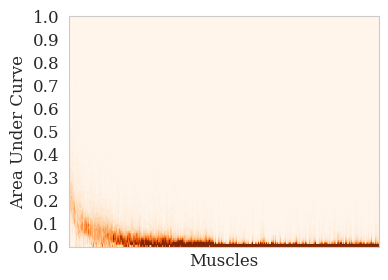

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

sns.set_style(style="whitegrid")
# Set global plot parameters for consistent styling
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "font.sans-serif": ["Helvetica"],
        "figure.figsize": (4, 3),  # Figure size
        "font.size": 12,  # Global font size
        "axes.titlesize": 12,  # Title font size
        "axes.labelsize": 12,  # Axes labels font size
        "xtick.labelsize": 12,  # X-tick labels font size
        "ytick.labelsize": 12,  # Y-tick labels font size
        "legend.fontsize": 12,  # Legend font size
        "figure.titlesize": 12,  # Figure title font size
    }
)

# Assuming you have the tensor `muscle_activations` with shape (602, 28, 402)

# Flatten the tensor to have shape (602, 402)
flattened_activations = auc_values

# Create an empty array to store the histogram values for each muscle
histogram_values = np.zeros((100, 402))
median_bins = np.zeros(402)

# Iterate over each muscle (column) in the flattened tensor
for i in range(402):
    # Calculate the histogram values for the muscle with 100 bins
    hist, _ = np.histogram(flattened_activations[:, i], bins=100, range=(0, 1))
    # Store the histogram values in the empty array
    histogram_values[:, i] = hist

    # Calculate the cumulative distribution function (CDF) for the muscle
    cdf = np.cumsum(hist) / np.sum(hist)
    # Find the bin index that corresponds to the median value (0.5) in the CDF
    median_bin_index = np.argmax(cdf >= 0.5)
    # Store the median bin index for the muscle
    median_bins[i] = median_bin_index

# Normalize the histogram values to the range [0, 1]
histogram_values = histogram_values / 602.0
histogram_values += 1e-6

# Sort the histograms based on their median bins
sorted_indices = np.argsort(median_bins)

# Reorder the columns of the histogram_values array based on the sorted indices
histogram_values = histogram_values[:, sorted_indices[::-1]]

# Create a logarithmic color map from 0 to 1
norm = LogNorm(vmin=np.min(histogram_values[histogram_values > 0]), vmax=np.max(histogram_values))

# Plot the histogram values as a two-dimensional color-coded histogram with logarithmic color map
plt.imshow(
    histogram_values,
    aspect="auto",
    cmap="Oranges",
    origin="lower",
    vmin=np.min(histogram_values[histogram_values > 0]),
    vmax=0.2,
)  # , norm=norm)
# Inverse the y-axis
# Set the y-axis ticks to go from 0 to 1
plt.yticks(np.linspace(0, 100, 11), np.round(np.linspace(0, 1, 11), decimals=2))
# plt.colorbar(label="Bin Counts")
plt.xlabel("Muscles")
plt.ylabel("Area Under Curve")
# plt.title("Histogram of Activation Area Under Curve", y=1.05)
# Deactivate the x-axis ticks
plt.xticks([])
# Deactivate the grid
plt.grid(False)
plt.savefig(f"muscle_auc.svg")
plt.show()

In [ ]:
# Mapping of muscle identifiers to their full names
muscle_idxs = [
    i for i, mus in enumerate(MUSCLE_SUBSETS["MUSINT_402"]) if mus in MUSCLE_SUBSETS["LAI_ARNOLD_LOWER_BODY_8"]
]

full_muscle_names = {
    "LU_glmed1_l": "Glut. Med. (L)",
    "LU_glmax2_l": "Glut. Max. (L)",
    "LU_recfem_l": "Rec. Fem. (L)",
    "LU_bflh_l": "Bic Fem. LH (L)",
    "LU_glmed1_r": "Glut. Med. (R)",
    "LU_glmax2_r": "Glut. Max. (R)",
    "LU_recfem_r": "Rec. Fem. (R)",
    "LU_bflh_r": "Bic Fem. LH (R)",
}

sample_indices = [
    (204, "Jumping Jacks"),
    (594, "Kick"),
    (582, "Run"),
    (389, "Walk"),
    (462, "Jump"),
    (137, "stand"),
    (279, "spin"),
    (120, "arm movements"),
    (238, "sports move"),
    (441, "backwards movement"),
    (169, "circular movement"),
    (536, "jump"),
    (382, "stomp"),
    (32, "dance"),
    (154, "backwards movement"),
    (356, "walk"),
    (35, "dance"),
    (11, "jump"),
    (526, "hand movements"),
    (591, "kick"),
    (580, "run"),
    (116, "crossing limbs"),
    (113, "wrist movements"),
    (245, "to lower a body part"),
    (117, "crossing limbs"),
    (428, "walk"),
    (240, "sports move"),
    (422, "drink"),
    (348, "place something"),
    (573, "scratch"),
    (562, "stretch"),
    (375, "walk"),
    (290, "turn"),
    (285, "walk"),
    (228, "turn"),
    (470, "walk"),
    (550, "take/pick something up"),
    (515, "walk"),
    (401, "walk"),
    (123, "arm movements"),
    (453, "turn"),
    (509, "walk"),
    (527, "jump"),
    (272, "action with ball"),
    (388, "walk"),
    (397, "walk"),
    (419, "walk"),
    (286, "walk"),
    (82, "leg movements"),
    (264, "catch"),
]

print(len(sample_indices))
# jumping jacks, kick, run, walk, jump

50


In [ ]:
", ".join(
    [
        f'({i}, "{sub_meta_df["actions"].iloc[i][0]}")'
        for i in np.random.choice(range(602), 150, replace=False)
        if len(sub_meta_df["actions"][i]) > 0
    ]
)

IndexError: list index out of range

['jumping jacks']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


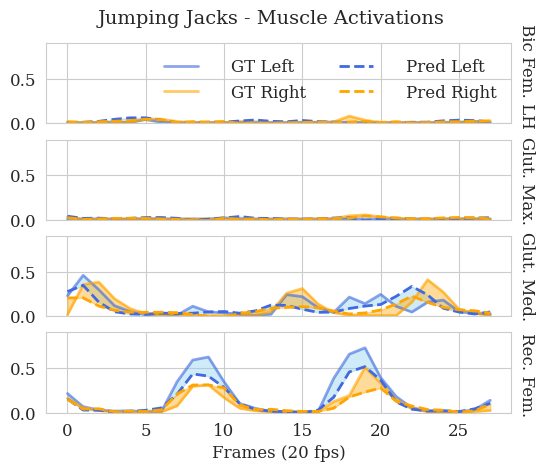

['kick']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


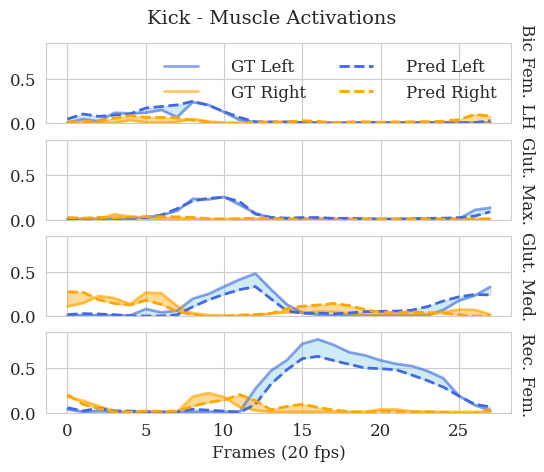

['run']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


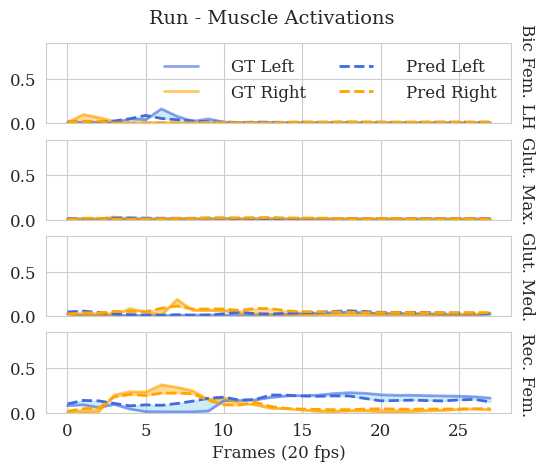

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


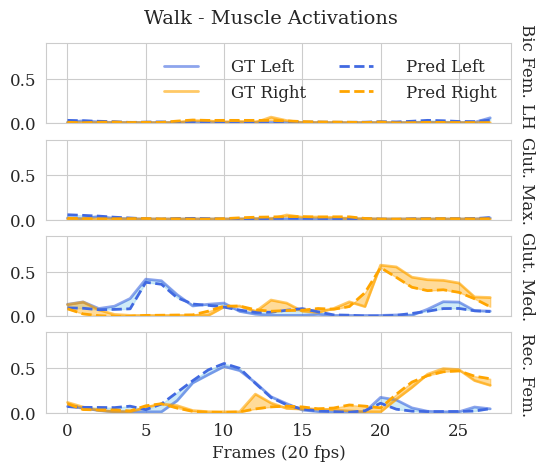

['jump']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


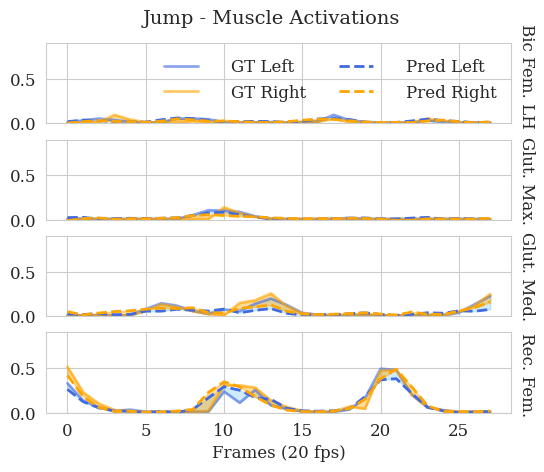

['stand']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


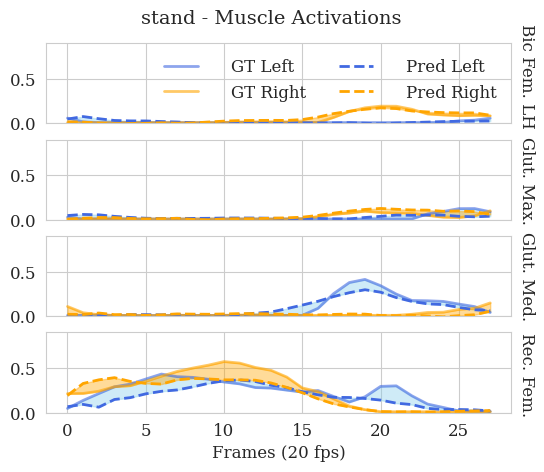

['walk', 'transition', 'spin']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


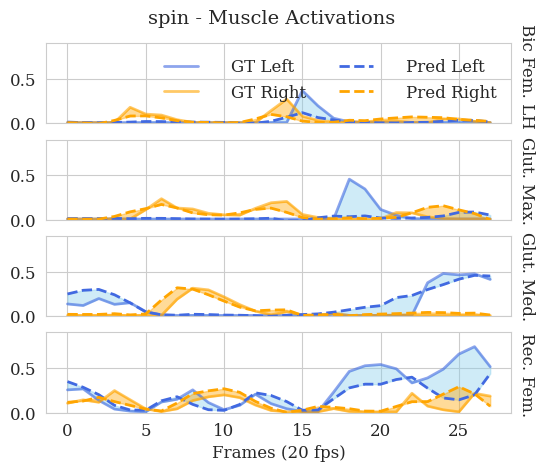

['arm movements', 'circular movement']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


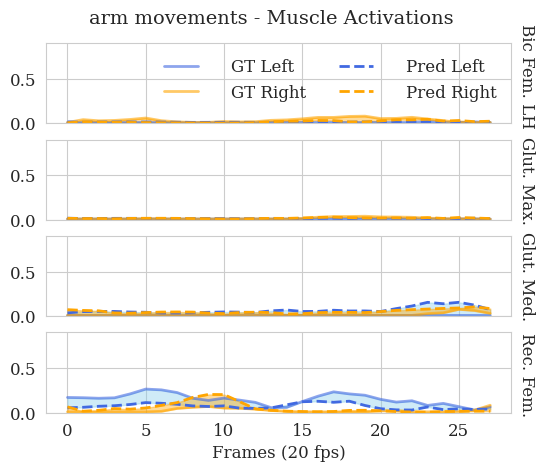

/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


['action with ball', 'play catch', 'sports move']


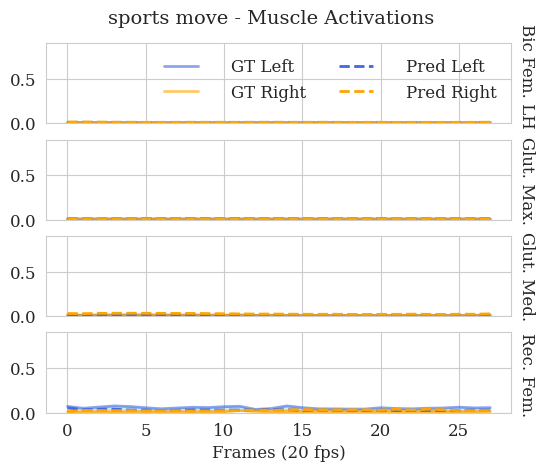

['walk', 'backwards movement']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


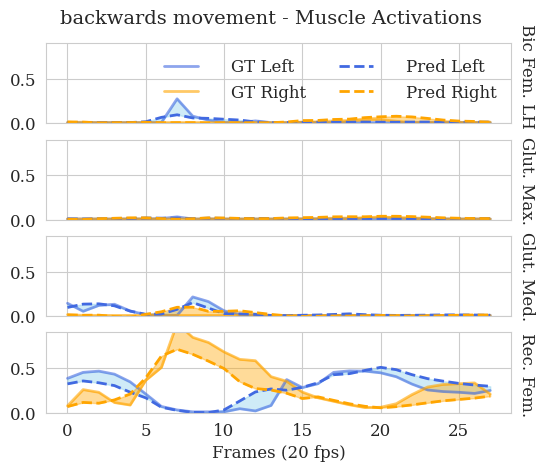

['circular movement', 'wrist movements']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


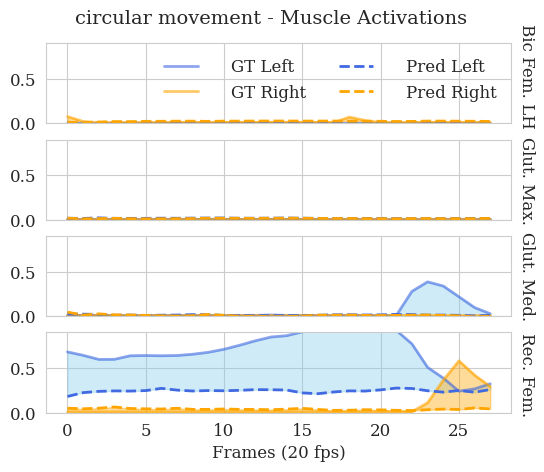

['stand']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


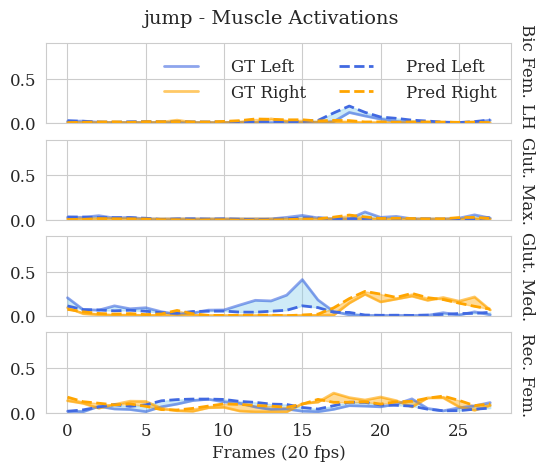

['foot movements', 'stomp']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


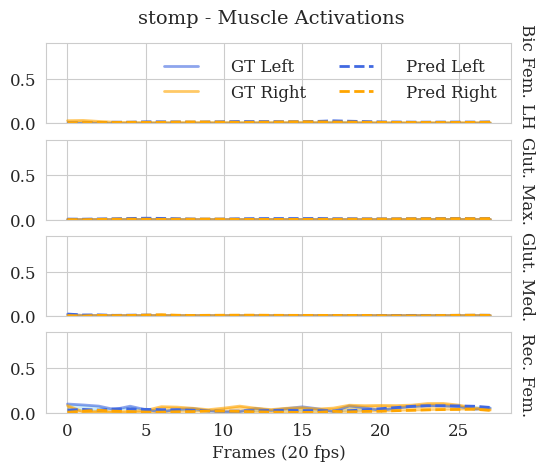

['dance', 'perform']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


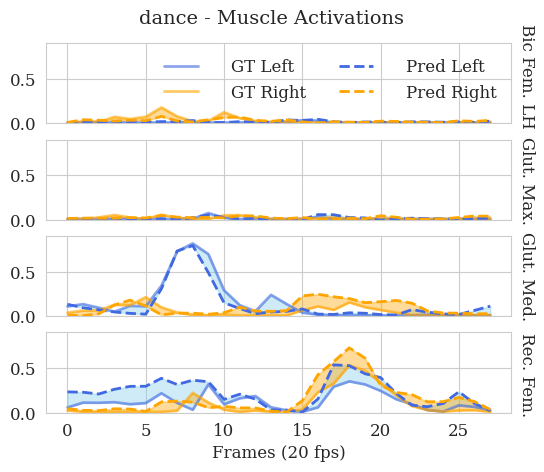

['backwards movement', 'transition', 'kick', 'leg movements']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


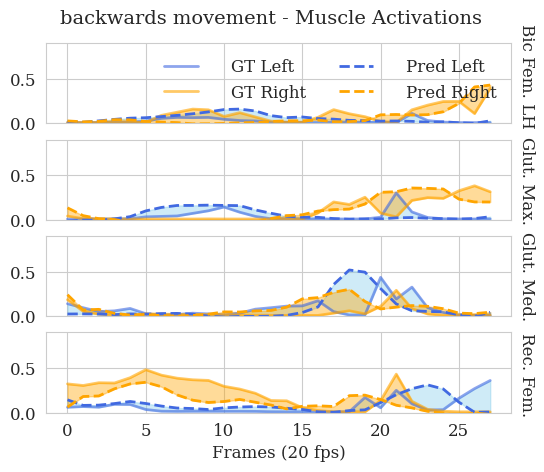

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


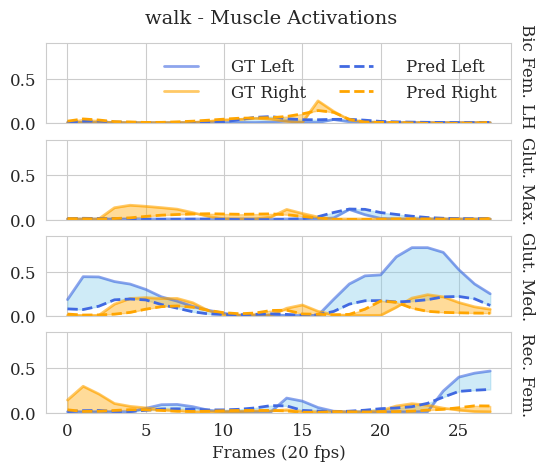

['dance', 'perform']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


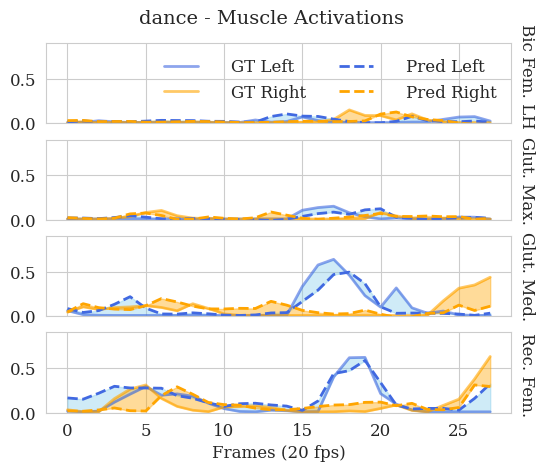

['jump']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


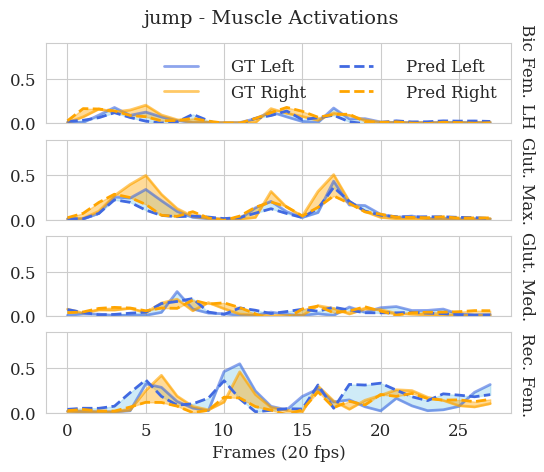

['transition', 'stand']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


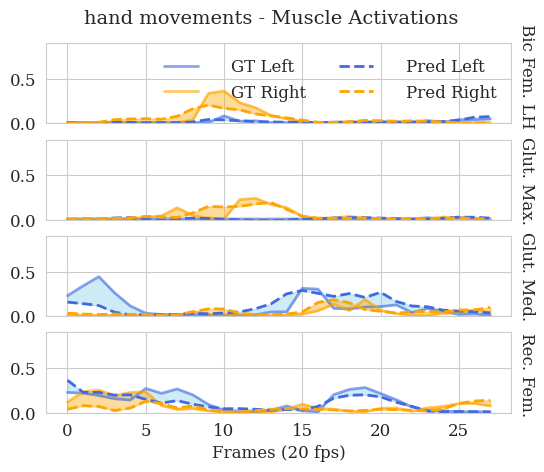

['step', 'sideways movement']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


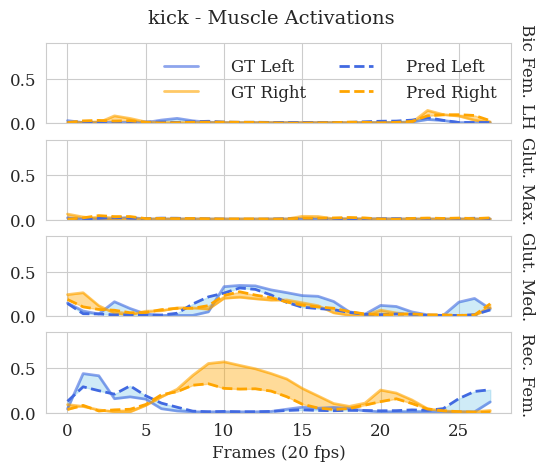

/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


['run']


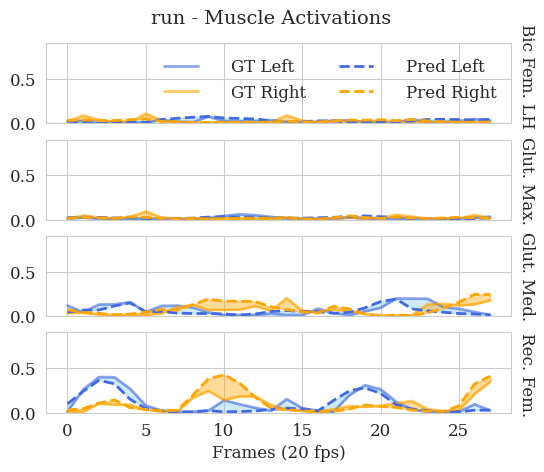

['arm movements', 'crossing limbs']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


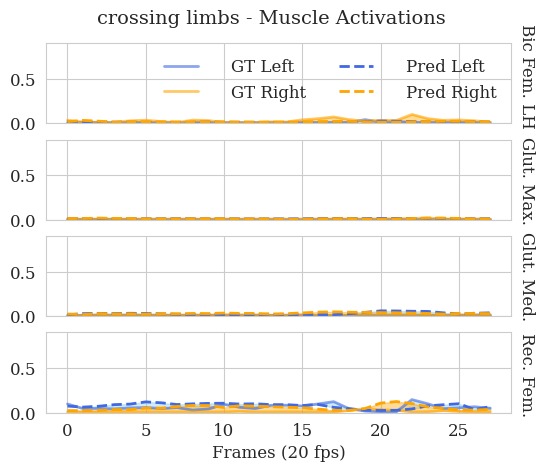

['circular movement', 'wrist movements']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


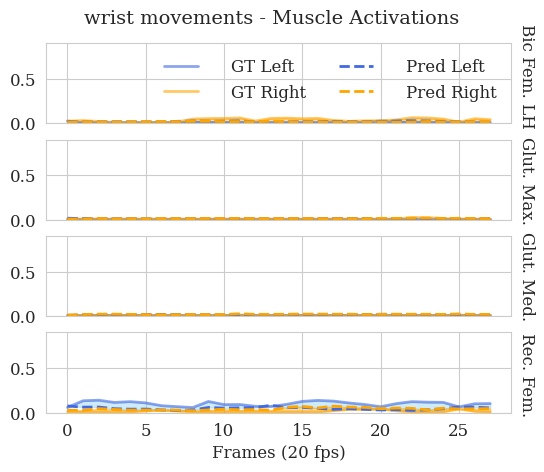

['turn', 'hand movements', 'to lower a body part', 'stand']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


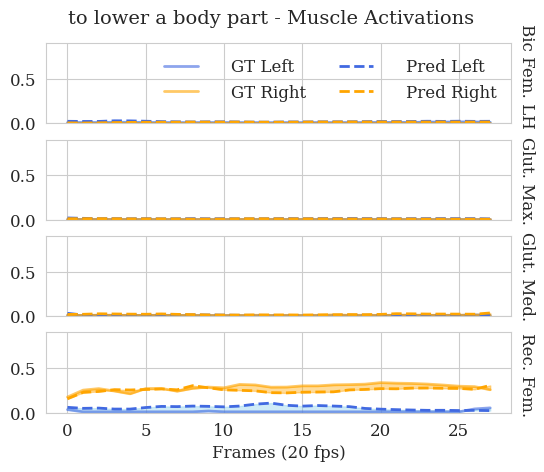

['arm movements', 'transition', 'crossing limbs']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


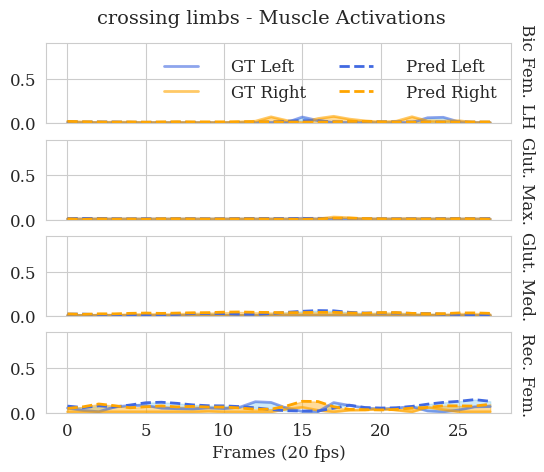

['foot movements', 'walk', 'transition', 'stand', 'spin']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


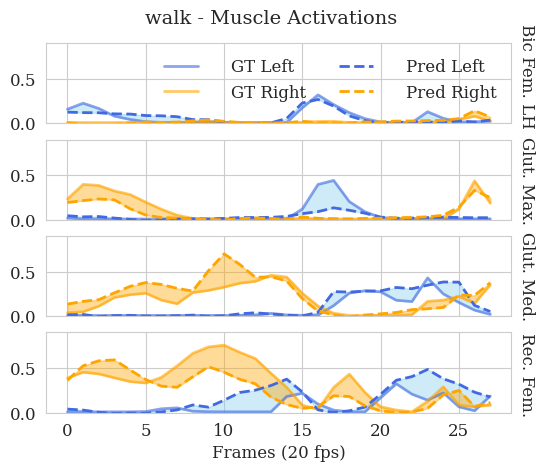

['action with ball', 'play catch', 'sports move']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


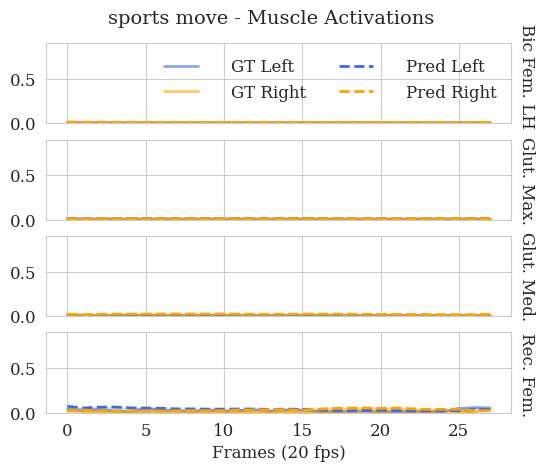

['drink']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


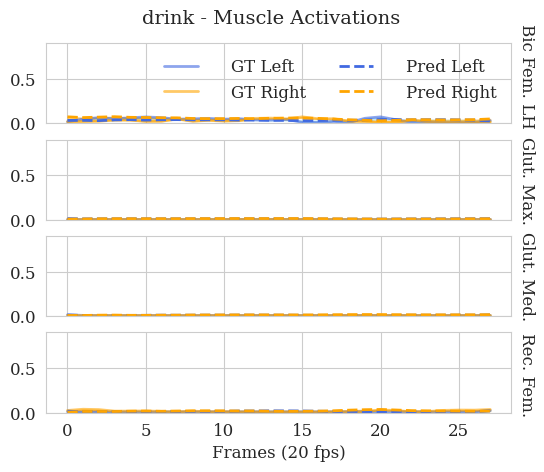

/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


['place something']


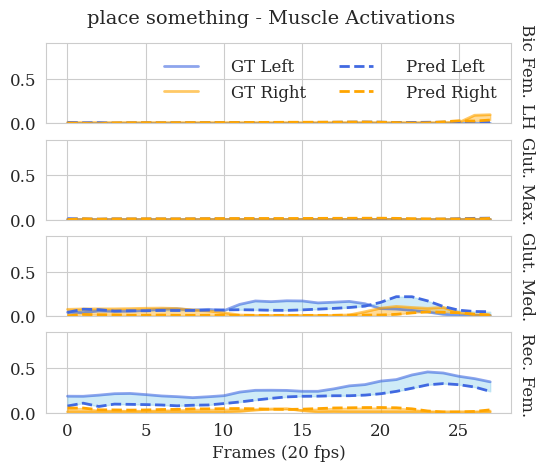

['walk', 'transition', 'turn']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


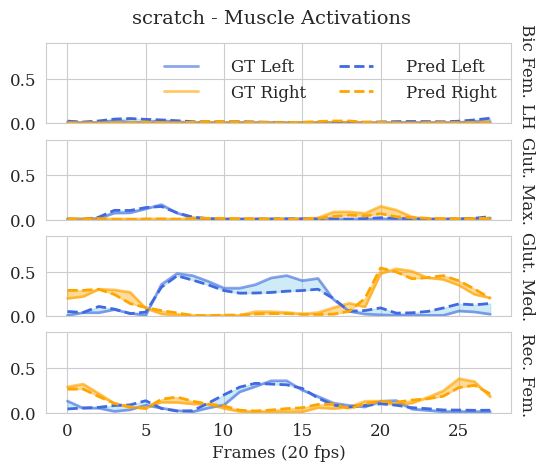

/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


['stand']


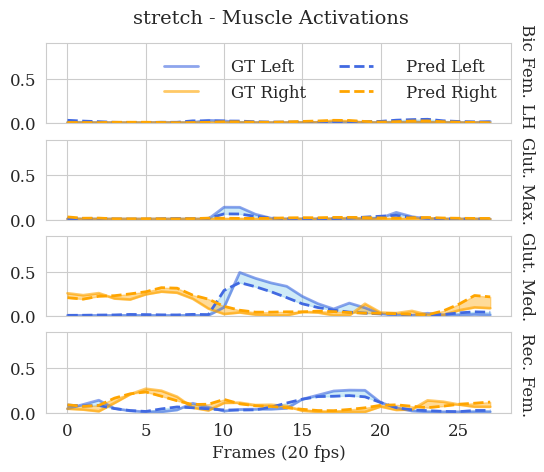

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


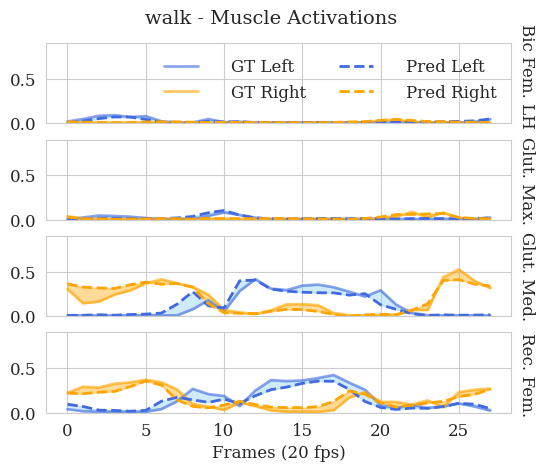

/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


['walk', 'turn']


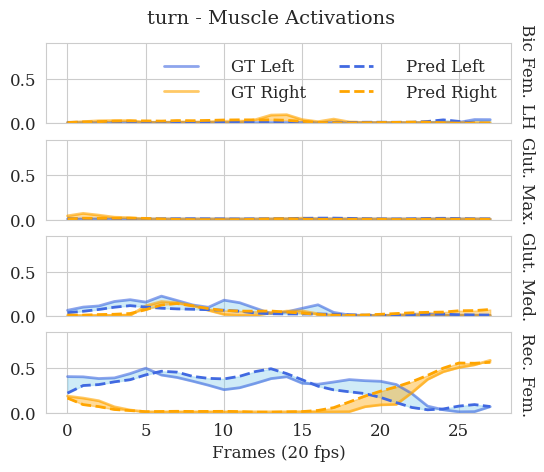

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


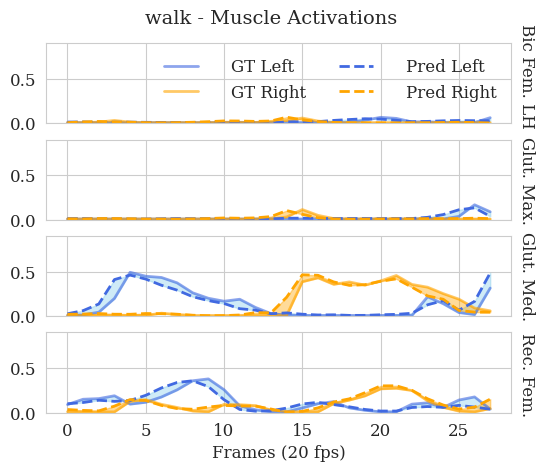

['walk', 'turn']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


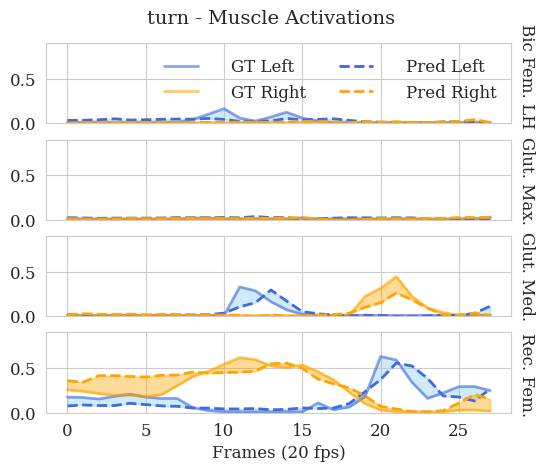

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


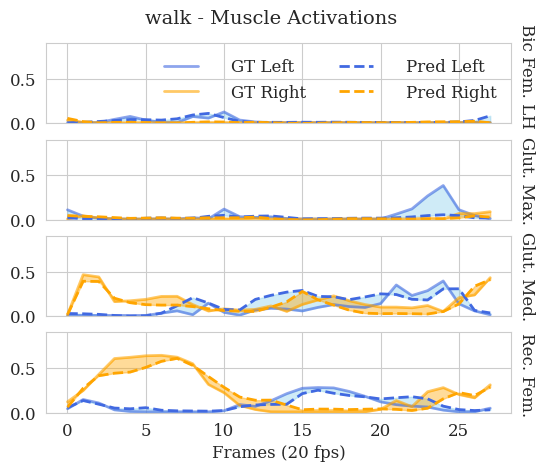

['take/pick something up', 'transition']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


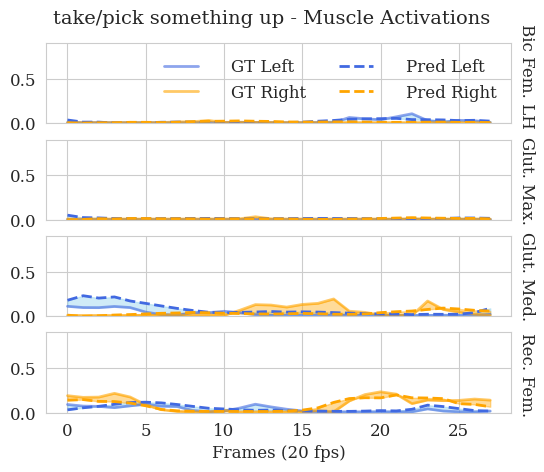

['interact with/use object']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


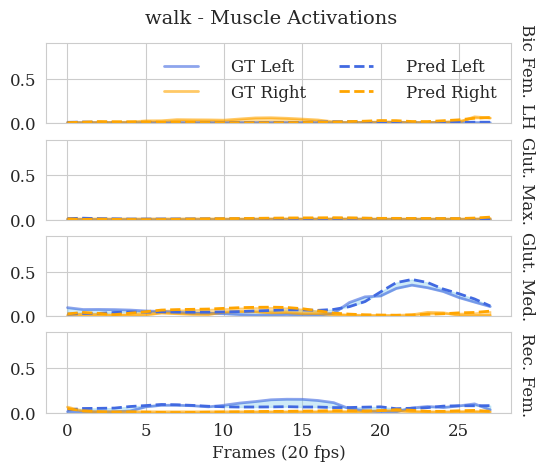

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


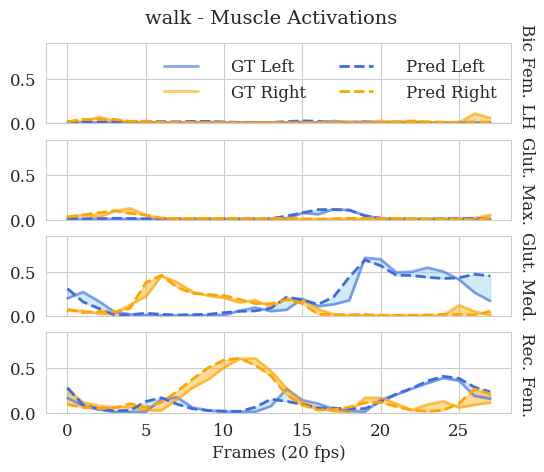

['arm movements', 'swing body part']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


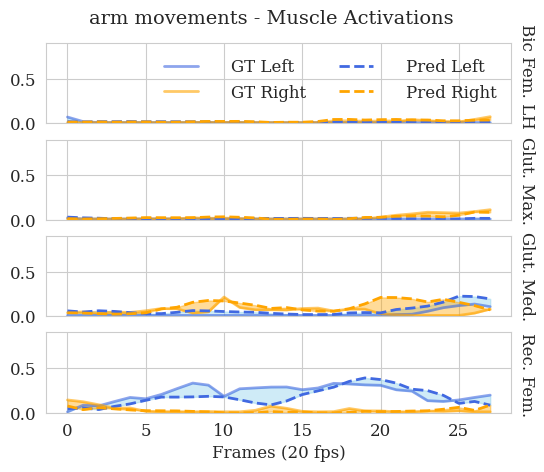

/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


['walk', 'turn']


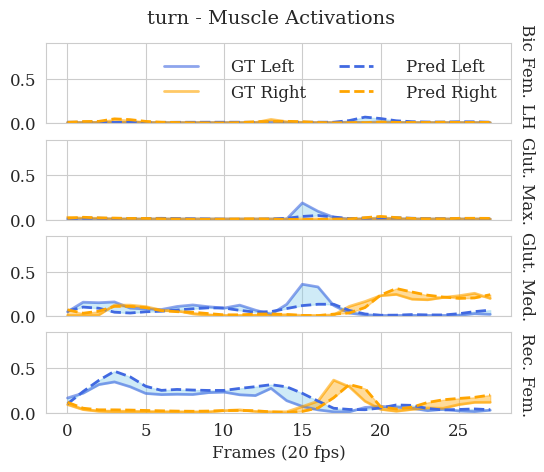

['walk', 'sideways movement']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


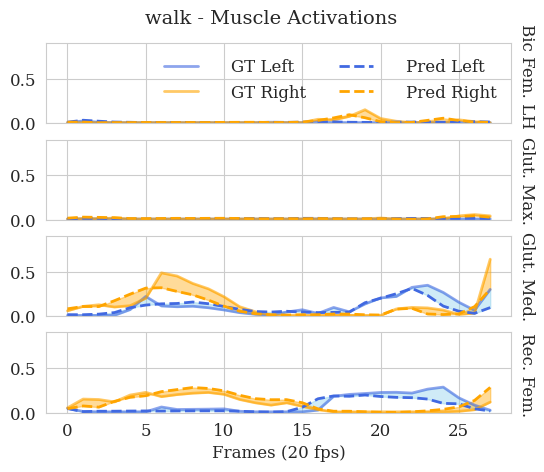

['hand movements', 'clap']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


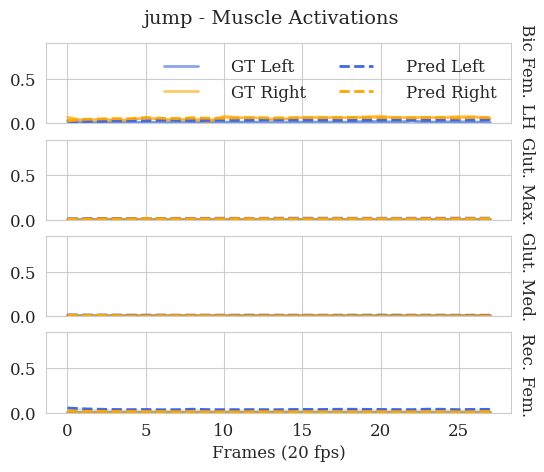

['throw', 'hand movements', 'transition', 'touching face', 'action with ball', 'stand']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


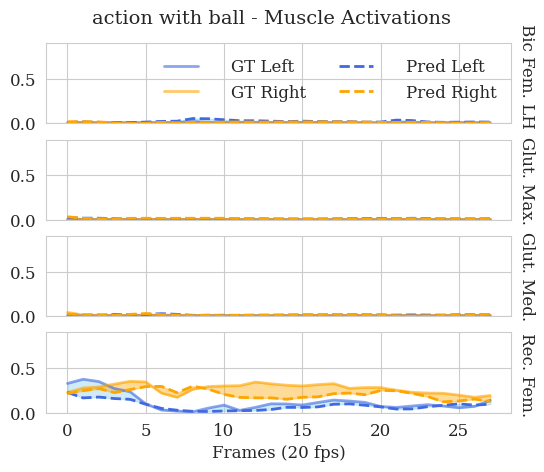

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


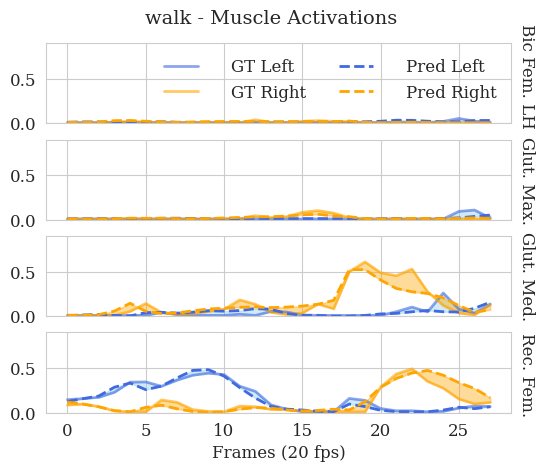

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


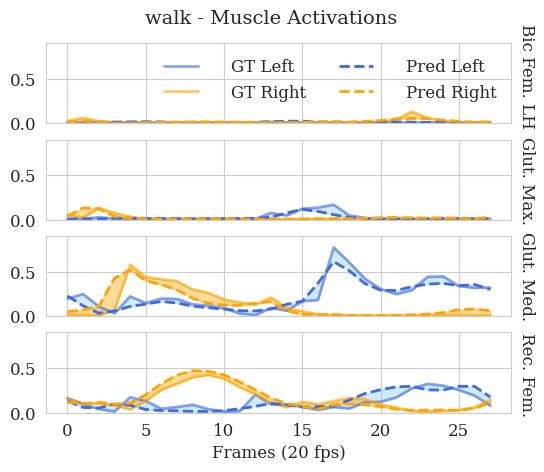

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


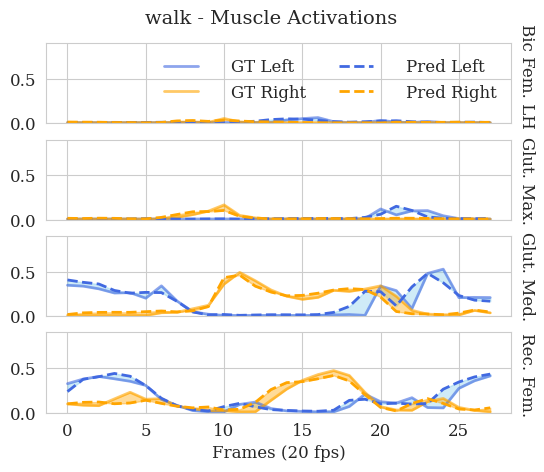

['walk']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


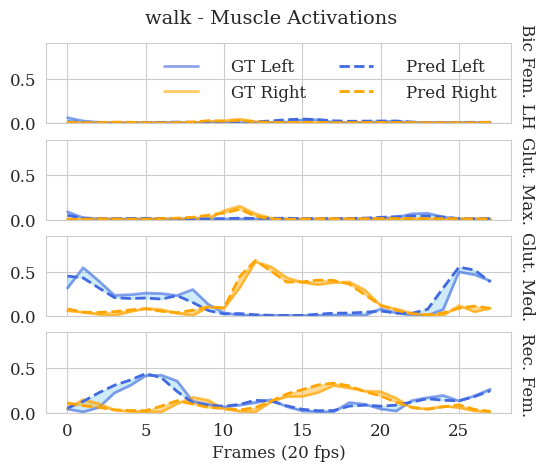

['swing body part', 'leg movements']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


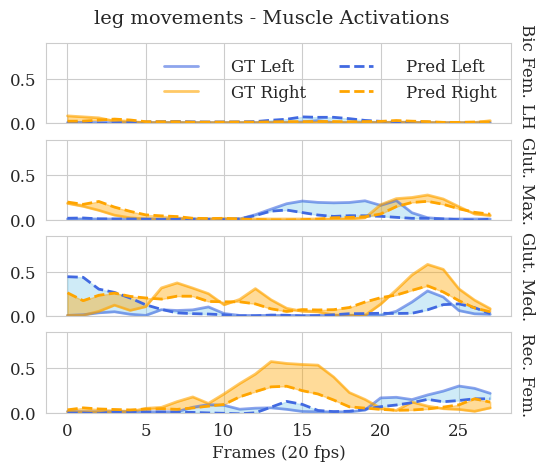

['throw', 'transition', 'catch', 'action with ball', 'stand']


/tmp/ipykernel_74780/627809168.py:98: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


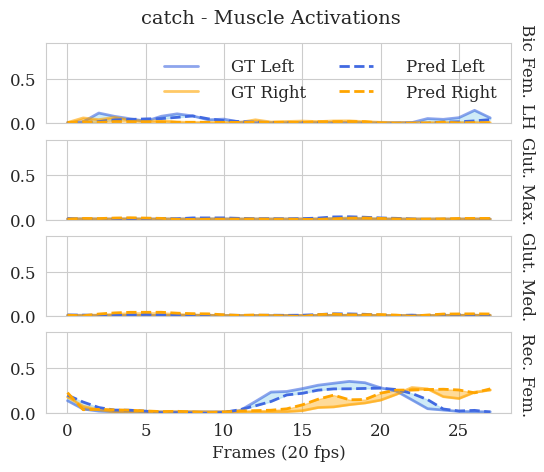

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

sns.set_style(style="whitegrid")


# Set global plot parameters for consistent styling
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "font.sans-serif": ["Helvetica"],
        "figure.figsize": (6, 4.8),  # Figure size
        "font.size": 12,  # Global font size
        "axes.titlesize": 12,  # Title font size
        "axes.labelsize": 12,  # Axes labels font size
        "xtick.labelsize": 12,  # X-tick labels font size
        "ytick.labelsize": 12,  # Y-tick labels font size
        "legend.fontsize": 12,  # Legend font size
        "figure.titlesize": 12,  # Figure title font size
    }
)


for i, (sample_idx, title) in enumerate(sample_indices):

    row = sub_meta_df.loc[sample_idx]
    print(row["actions"])
    # Get ground truth and prediction file names from the row
    gt_file = row["gt_name"]
    pred_file = row["pred_name"]

    gt_path = os.path.join(muscle_act_root, gt_file)
    pred_path = os.path.join(muscle_act_root, pred_file)

    # Load ground truth and prediction data
    gt = np.load(gt_path)[..., muscle_idxs]
    pred = np.load(pred_path)[..., muscle_idxs]

    T, D = gt[0].shape
    plt.figure()

    counter = 0

    for li in range(0, int(len(muscle_idxs) / 2)):
        ri = li + int(len(muscle_idxs) / 2)  # Right index

        muscle_l = MUSCLE_SUBSETS["MUSINT_402"][muscle_idxs[li]]
        muscle_r = MUSCLE_SUBSETS["MUSINT_402"][muscle_idxs[ri]]

        muscle_name_l = full_muscle_names[muscle_l]
        muscle_name_r = full_muscle_names[muscle_r]

        counter += 1

        plt.subplot(int(D / 2), 1, counter)

        x = np.arange(len(gt[0][:, li]))
        x_new = np.linspace(x.min(), x.max(), len(x) * 10)

        gt_l = gt[0][:, li]
        gt_r = gt[0][:, ri]

        pred_l = pred[0][:, li]
        # pred_l = interp1d(x, pred_l, kind="cubic")(x_new)

        pred_r = pred[0][:, ri]

        plt.plot(gt_l, label=f"GT Left", linewidth=2, color="royalblue", alpha=0.6)
        plt.plot(gt_r, label=f"GT Right", linewidth=2, color="orange", alpha=0.6)

        plt.plot(pred_l, label=f"Pred Left", linestyle="--", linewidth=2, color="royalblue")
        plt.plot(pred_r, label=f"Pred Right", linestyle="--", linewidth=2, color="orange")

        plt.fill_between(range(len(gt_l)), gt_l, pred_l, color="skyblue", alpha=0.4)
        plt.fill_between(range(len(gt_r)), gt_r, pred_r, color="orange", alpha=0.4)
        plt.yticks([0, 0.5])
        plt.title(f"{muscle_name_l[:-4]}", rotation=-90, loc="right", x=1.05, y=-0.11)

        # plt.ylabel(f"Activation")
        # Hide x-axis for all but the last subplot
        if counter != int(D / 2):
            # plt.yticks([])
            # plt.gca().xaxis.set_ticks([])
            plt.gca().set_xticklabels([])
            plt.gca().xaxis.grid(True)  # Ensure x-axis grid is visible
        else:
            plt.xlabel("Frames (20 fps)")

        plt.ylim((0, 0.9))
        plt.grid(True)

    # plt.ylabel(f"Activation", y=2.2)
    plt.legend(loc="upper right", bbox_to_anchor=(1.0012, 4.59), ncol=2, frameon=False, handletextpad=2)
    plt.tight_layout()
    plt.suptitle(f"{title} - Muscle Activations", fontsize=14, y=0.95)
    plt.savefig(f"output/aviz/{i}.svg")
    plt.show()